In [18]:
# !nvidia-smi

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null

replace 64x64/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [21]:
## libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, glob, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Convolution1D, Convolution2D, MaxPooling2D, Flatten, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPool2D, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics

## Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

# CNN 1.0 - Binary output (attack/normal)

In [22]:
train_normal = []
train_attack = []
test_normal = []
test_attack = []

for i in glob.glob('/content/64x64/train_normal/train_normal_*.jpg', recursive=True):
    train_normal.append(cv2.imread(i, cv2.IMREAD_GRAYSCALE))

for j in glob.glob('/content/64x64/train_attack/train_attack_*.jpg', recursive=True):
    train_attack.append(cv2.imread(j, cv2.IMREAD_GRAYSCALE))

for k in glob.glob('/content/64x64/test_normal/test_normal_*.jpg', recursive=True):
    test_normal.append(cv2.imread(k, cv2.IMREAD_GRAYSCALE))

for l in glob.glob('/content/64x64/test_attack/test_attack_*.jpg', recursive=True):
    test_attack.append(cv2.imread(l, cv2.IMREAD_GRAYSCALE))

train_normal = np.array(train_normal)
train_attack = np.array(train_attack)
test_normal = np.array(test_normal)
test_attack = np.array(test_attack)

In [23]:
np.shape(train_normal), np.shape(train_attack), np.shape(test_normal), np.shape(test_attack)

# for i in range(0, 2):
#   plt.imshow(train_normal[i], cmap = 'gray')
#   plt.show()

# for i in train_normal:
#   print(i)

((1874, 64, 64), (1628, 64, 64), (271, 64, 64), (357, 64, 64))

In [24]:
## augmenting the data to create more images
## only run cell if needed

## vertically flip training images
vert_flip_train_attack = np.fliplr(train_attack)
vert_flip_train_normal = np.fliplr(train_normal)

## flip training images horizonatally
hor_flip_train_attack = np.rot90(train_attack, axes = (1,2), k = 2)
hor_flip_train_normal = np.rot90(train_normal, axes = (1,2), k = 2)

## rotate training images left and right once each
rotate90l_train_attack = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_attack = np.rot90(train_normal, -1, axes=(1, 2))
rotate90l_train_normal = np.rot90(train_attack, axes=(1, 2))
rotate90r_train_normal = np.rot90(train_normal, -1, axes=(1, 2))



## vertically flip testing images
vert_flip_test_attack = np.fliplr(test_attack)
vert_flip_test_normal = np.fliplr(test_normal)

## flip testing images horizonatally
hor_flip_test_attack = np.rot90(test_attack, axes = (1,2), k = 2)
hor_flip_test_normal = np.rot90(test_normal, axes = (1,2), k = 2)

## rotate testing images left and right once each
rotate90l_test_attack = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_attack = np.rot90(test_normal, -1, axes=(1, 2))
rotate90l_test_normal = np.rot90(test_attack, axes=(1, 2))
rotate90r_test_normal = np.rot90(test_normal, -1, axes=(1, 2))


## stack all the original and augmented data to one single numpy array
train = np.vstack((train_attack, vert_flip_train_attack, hor_flip_train_attack,
                   train_normal, vert_flip_train_normal, hor_flip_train_normal))
test = np.vstack((test_attack, vert_flip_test_attack, hor_flip_test_attack,
                  test_normal, vert_flip_test_normal, hor_flip_test_normal))

In [80]:
## if no augmented data is needed, run this cell
train = np.vstack((train_normal, train_attack))
test = np.vstack((test_normal, test_attack))

In [81]:
train.shape, test.shape

((3502, 64, 64), (628, 64, 64))

In [25]:
train = train.reshape(-1,64,64,1)
test = test.reshape(-1,64,64,1)

In [26]:
train.shape, test.shape

((10506, 64, 64, 1), (1884, 64, 64, 1))

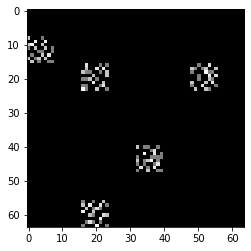

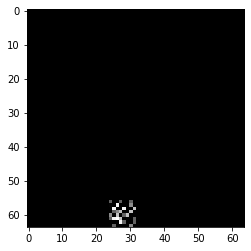

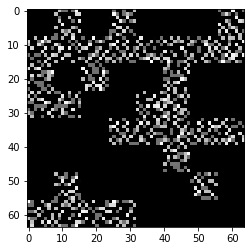

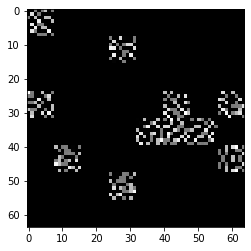

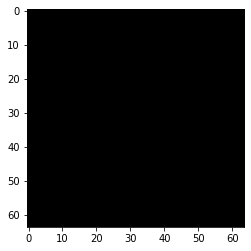

In [9]:
for i in range(0, 5):
    plt.imshow(tf.squeeze(train[i]), cmap = 'gray')
    plt.show()

In [84]:
## create the training and testing data labels
## run if not using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [27]:
## create the training and testing data labels
## run this cell if using augmented data

training_labels = []
## add the attack labels
for i in range(0, train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0]):
    training_labels.append('attack')

## add the normal labels
for j in range(train_attack.shape[0] + vert_flip_train_attack.shape[0] + hor_flip_train_attack.shape[0], train.shape[0]):
    training_labels.append('normal')



testing_labels = []
## add the attack labels
for k in range(0, test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0]):
    testing_labels.append('attack')

## add the normal labels
for l in range(test_attack.shape[0] + vert_flip_test_attack.shape[0] + hor_flip_test_attack.shape[0], test.shape[0]):
    testing_labels.append('normal')

In [28]:
## create the dataframe for labels, then OHE the column
ytrain = pd.DataFrame(training_labels, columns = ['category'])
ytest = pd.DataFrame(testing_labels, columns = ['category'])

ytrain = pd.get_dummies(ytrain['category'])
ytest = pd.get_dummies(ytest['category'])

ytrain, ytest

(       attack  normal
 0           1       0
 1           1       0
 2           1       0
 3           1       0
 4           1       0
 ...       ...     ...
 10501       0       1
 10502       0       1
 10503       0       1
 10504       0       1
 10505       0       1
 
 [10506 rows x 2 columns],       attack  normal
 0          1       0
 1          1       0
 2          1       0
 3          1       0
 4          1       0
 ...      ...     ...
 1879       0       1
 1880       0       1
 1881       0       1
 1882       0       1
 1883       0       1
 
 [1884 rows x 2 columns])

In [29]:
## shuffle the data to prevent pattern recognition
train, ytrain = sklearn.utils.shuffle(train, ytrain, random_state = 0)
test, ytest = sklearn.utils.shuffle(test, ytest, random_state = 0)

In [30]:
cnn = Sequential()

## convolution 1
cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 2
cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 3
cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Dropout(0.5))

## convolution 4
cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# # cnn.add(Dropout(0.5))

cnn.add(Flatten())

## dense
cnn.add(Dense(128, activation='relu'))
# cnn.add(Dense(256, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation = 'sigmoid'))

# callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

cnn.compile(optimizer = keras.optimizers.Adamax(), loss = 'binary_crossentropy',
            metrics = ['accuracy'])


cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 16)        80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [31]:
# start = time.time()
model_history = cnn.fit(train, ytrain, batch_size = 512, epochs = 500)
# end = time.time()

# os.system(f'say "training finished in {round(end - start, 2)} seconds"')
# print(f'Training finished in {round(end - start, 2)}')

Epoch 1/500
 8/21 [==========>...................] - ETA: 15s - loss: 8.4355 - accuracy: 0.4591

KeyboardInterrupt: ignored

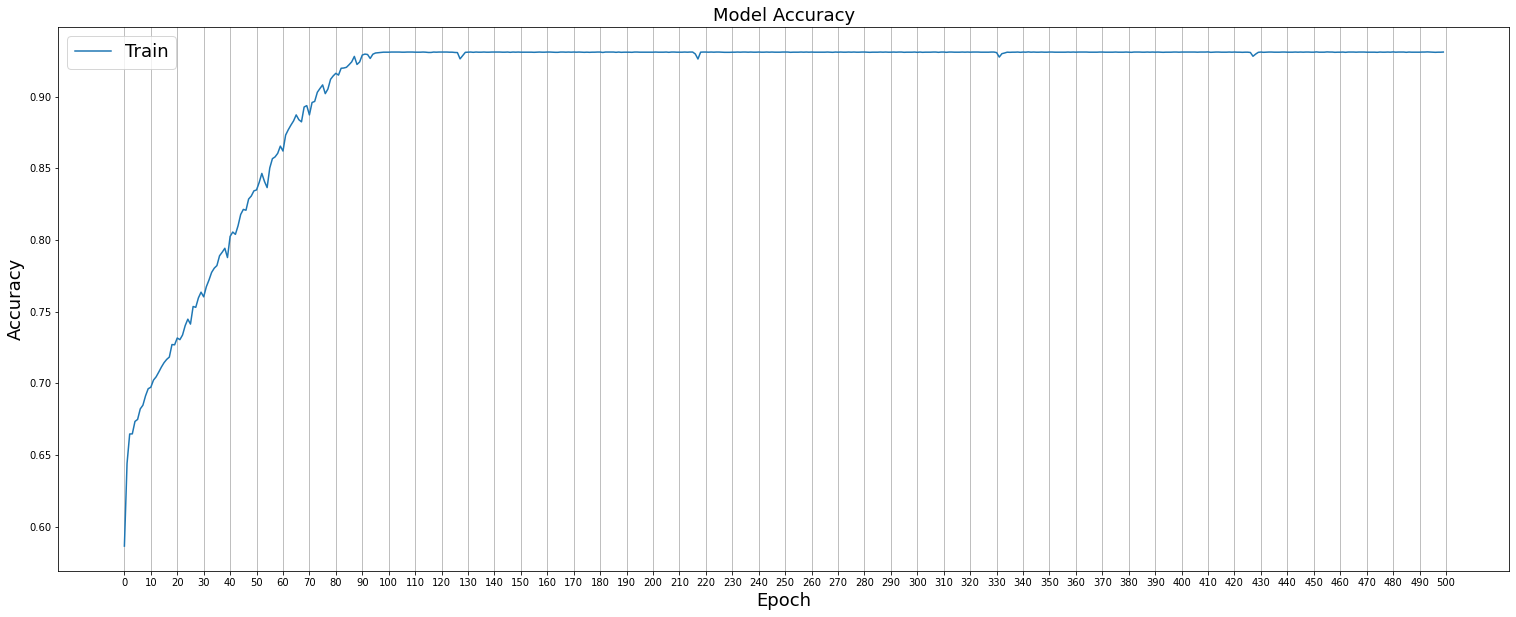

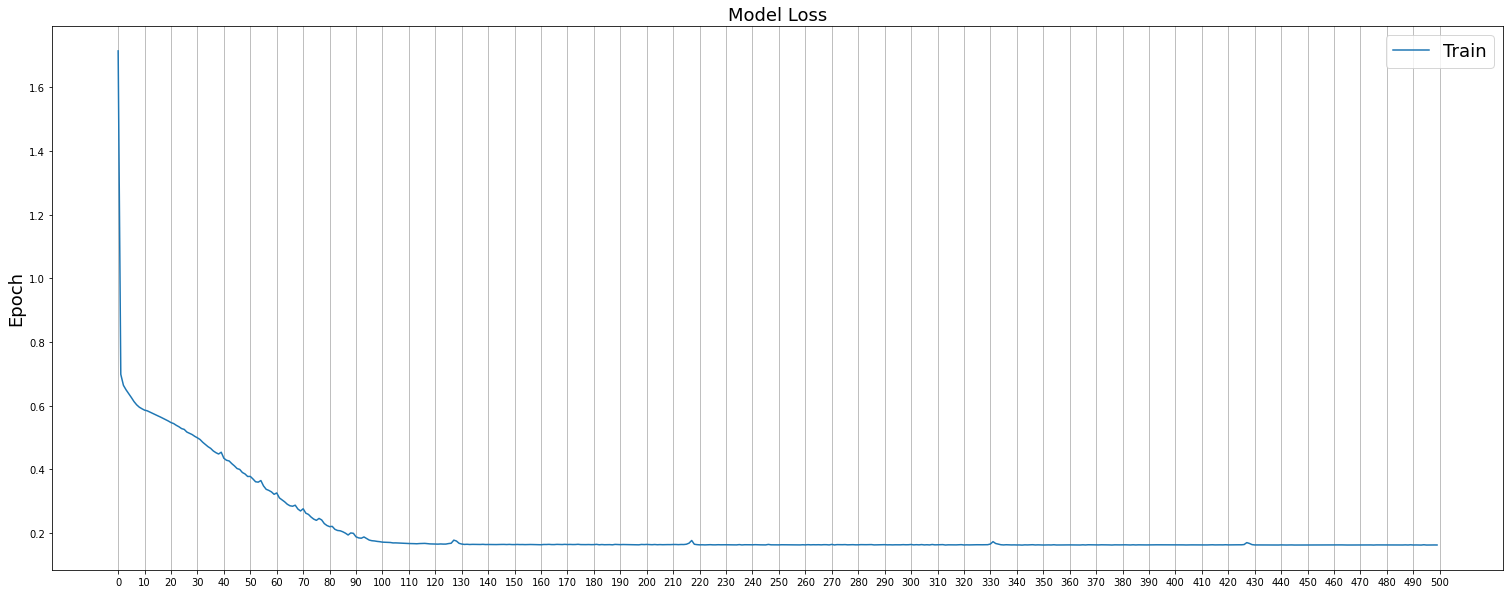

In [230]:
# print(model_history.history.keys())

figure(figsize = (26,10))
plt.plot(model_history.history['accuracy'])
# plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 510, step = 10))
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

print()

figure(figsize = (26,10))
plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
plt.title('Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.ylabel('Epoch', fontsize = 18)
plt.xticks(np.arange(0, 510, step = 10), )
plt.legend(['Train', 'Test'], loc = 'best', fontsize = 18)
plt.grid(axis = 'x')
plt.show()

In [231]:
loss, acc = cnn.evaluate(test, ytest, batch_size = 512, verbose = 0)
print(f'Loss = {round(loss, 4)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 3.7487	Accuracy = 57.96%


In [232]:
preds = cnn.predict(test)
y_preds = np.argmax(preds, axis = 1)

preds[:20]

array([[0.01422, 0.97947],
       [0.96329, 0.0211 ],
       [0.31028, 0.96488],
       [0.01606, 0.98417],
       [0.22946, 0.77048],
       [1.     , 0.     ],
       [0.01978, 0.97729],
       [0.91874, 0.05641],
       [0.99947, 0.00013],
       [0.22946, 0.77048],
       [0.22946, 0.77048],
       [1.     , 0.     ],
       [0.     , 1.     ],
       [1.     , 0.     ],
       [0.     , 1.     ],
       [0.00074, 0.99929],
       [0.01935, 0.99363],
       [0.00003, 0.99997],
       [0.99995, 0.00005],
       [0.22946, 0.77048]], dtype=float32)

In [241]:
def build_classifier():
    
    cnn = Sequential()

    ## convolution 1
    cnn.add(Convolution2D(16, (2,2), padding="same", activation='relu', input_shape = (64,64,1)))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 2
    cnn.add(Convolution2D(32, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 3
    cnn.add(Convolution2D(64, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 4
    cnn.add(Convolution2D(128, (2,2), padding="same", activation='relu'))
    cnn.add(MaxPooling2D(pool_size = (2,2)))
    # # cnn.add(Dropout(0.5))

    # ## convolution 5
    # cnn.add(Convolution2D(256, (2,2), padding="same", activation='relu'))
    # cnn.add(AveragePooling2D(pool_size = (2,2)))
    # cnn.add(Dropout(0.5))

    ## convolution 6
    # cnn.add(Convolution2D(512, (2,2), padding="same", activation='relu'))
    # cnn.add(MaxPooling2D(pool_size = (1,1)))
    # cnn.add(Dropout(0.5))

    cnn.add(Flatten())

    ## dense
    cnn.add(Dense(128, activation='relu'))
    # cnn.add(Dense(256, activation='relu'))
    # cnn.add(Dropout(0.5))
    cnn.add(Dense(2, activation = 'sigmoid'))

    # callback = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 2)]

    cnn.compile(optimizer = keras.optimizers.Adamax(), loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    
    return cnn

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 512, epochs = 500)

In [242]:
scores = cross_val_score(estimator = classifier, X = test, y = ytest.values, cv = 5, n_jobs = -1)
print(f'Model Cross Validation: \n{round(scores.mean(), 3)*100}%')
print(f'Model Cross Validation: \n{scores}')

os.system('say "cross validation finished" ')

Model Cross Validation: 
nan%
Model Cross Validation: 
[    nan 0.70557     nan     nan     nan]


32512